<a href="https://colab.research.google.com/github/dowrave/Kaggle_Competition/blob/main/Kaggle_GAN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## 데이터 준비

https://www.kaggle.com/competitions/gan-getting-started

In [ ]:
!kaggle competitions download -c gan-getting-started
!unzip '*.zip'

In [47]:
import pathlib
paint_dir = pathlib.Path('./monet_jpg/')
image_count = len(list(paint_dir.glob('*.jpg')))
print(image_count)

300


In [48]:
photo_dir = pathlib.Path('./photo_jpg/')
photo_count = len(list(photo_dir.glob('*.jpg')))

#### Pathlib
- 파이썬 3.4부터 추가된 모듈
- Path 메서드를 통해 Path 객체를 생성할 수 있다. 이 객체를 조작하는 게 핵심.
  - `Path.glob` : 경로 내의 파일을 얻을 수 있음
    - `glob('*')` : 모든 폴더 & 파일
    - `glob('**/*')` : 모든 폴더 & 파일 (하위 폴더의 파일까지)

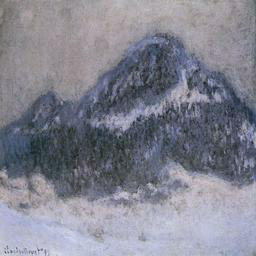

In [49]:
import PIL
paint = list(paint_dir.glob('*.jpg'))
photo = list(photo_dir.glob('*.jpg'))
PIL.Image.open(paint[0]) # str(paint[0])이 아니어도 잘 작동한다.

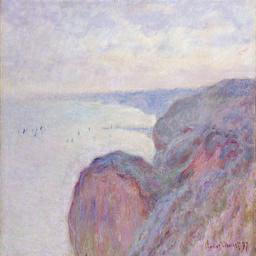

In [50]:
PIL.Image.open(paint[1])

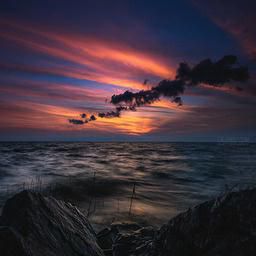

In [51]:
PIL.Image.open(photo[0])

### 데이터 로드하기 1.
`tf.keras.preprocessing.image_dataset_from_directory`를 이용한다.
- `[-1, 1]` 전처리를 위해선 데이터셋에 넣기 전에 표준화를 적용해야 함

In [151]:
# 2. 에서 tf.io.gfile.glob으로 잡으면 텐서 되는 거 아닐까?에서 시작해보자
paint_filenames = tf.io.gfile.glob('monet_jpg/*.jpg')
print(len(paint_filenames))
photo_filenames = tf.io.gfile.glob('photo_jpg/*.jpg')
print(len(photo_filenames))

300
7038


In [157]:
# 일단 이렇게 지정하면 얘네는 Path 객체가 아니라 string으로 잡히는 것 같음 
tf.io.read_file(paint_filenames)

InvalidArgumentError: ignored

In [52]:
# 데이터세트 만들기 : 일부 파라미터 정의
## 참고 : 이 Competition의 데이터셋은 256 * 256 으로 이미 정의되어 있긴 함
import tensorflow as tf

batch_size = 32
img_height = 256
img_width = 256

### tf.keras.preprocessing.image_dataset_from_directory 사용 시 유의점
- 데이터셋을 만들 때 label을 부여하려 하는데, <b>기본적으로</b> 어떤 하위 폴더에 들어있느냐에 따라 label이 달라진다.
- 파라미터 `label=None`으로 하지 않으면 지정한 경로 바로 밑의 이미지는 `.jpg` 확장자 명을 가지더라도 찾지 못한다.
- 분류가 필요없는 경우는 `label=None`으로 지정해주자.
- 한 30분 헤멤 ㅎㅎ!

In [61]:
# labels = None이 있어야 지정한 경로 바로 밑에 있는 이미지들을 탐색하며
  # 디폴트값이면 경로 밑의 subfolder를 필요로 함. 각 폴더마다 labeling을 하기 때문임(subfolder가 없으면 이미지 탐색 X)
  # Path 객체를 집어넣어도 경로명 넣은 것처럼 작동한다.

# 이거 찾는 데 30분 걸림. 오류 탐색엔 역시 라이브러리 폴더가 갑이다.
paint_ds = tf.keras.preprocessing.image_dataset_from_directory(
    paint_dir,
    labels = None,
    seed = 0,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

photo_ds = tf.keras.preprocessing.image_dataset_from_directory(
    photo_dir,
    labels = None,
    seed = 0,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


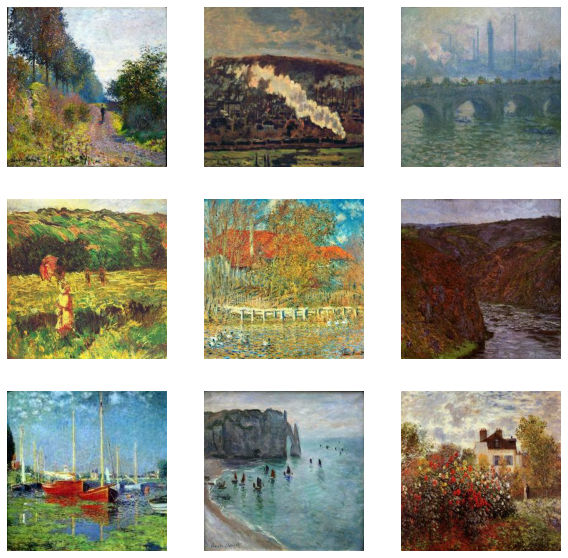

In [86]:
# 데이터 시각화
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for img_batch in paint_ds: # paint_ds.take()를 사용하지 않는다 : label이 1개여서?
  # print(img_batch.shape)
  for i in range(3):
    for j in range(3):
      ax[i, j].imshow(img_batch[3*i + j].numpy().astype('uint8'))
      ax[i, j].axis('off')


## 데이터 로드하기 2
- tfrec 폴더를 이용하는 방법이다. 
- tfrec는 TFRecordDataset에 집어넣을 수 있는 것 같다

In [140]:
PAINT_FILENAMES = tf.io.gfile.glob('monet_tfrec/*.tfrec')
PHOTO_FILENAMES = tf.io.gfile.glob('photo_tfrec/*.tfrec')
len(PAINT_FILENAMES), len(PHOTO_FILENAMES)

(5, 20)

In [145]:
image_size = [256, 256]

def decode_image(image):
  image = tf.image.decode_jpeg(image, channels = 3)
  image = (tf.cast(image, tf.float32) / 127.5) - 1
  image = tf.reshape(image, [*image_size, 3])
  return image

def read_tfrecord(example):
  tfrecord_format = {
      "image_name" : tf.io.FixedLenFeature([], tf.string),
      "image" : tf.io.FixedLenFeature([], tf.string),
      "target" : tf.io.FixedLenFeature([], tf.string)
  }
  example = tf.io.parse_single_example(example, tfrecord_format)
  image = decode_image(example['image'])
  return image

In [146]:
def load_dataset(filenames, labeled = True, ordered = False):
  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
  return dataset

In [147]:
# 아래 코드를 보면 *.tfrec 파일들은 데이터셋인가보다
paint_ds = load_dataset(PAINT_FILENAMES, labeled = True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled = True).batch(1)


In [148]:
example_paint = next(iter(paint_ds))
example_photo = next(iter(photo_ds))

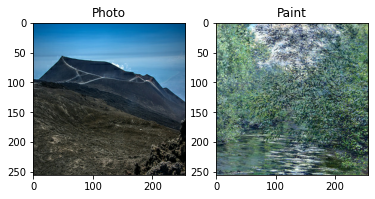

In [150]:
plt.subplot(121)
plt.title("Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Paint")
plt.imshow(example_paint[0] * 0.5 + 0.5)

### 데이터 표준화하기
- `[0, 1]`로 하든, `[-1, 1]`로 하든 고르세용

In [134]:
# norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255) # [0, 1]
norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 127.5, offset = -1) # [-1, 1]
paint_ds = norm_layer(paint_ds)
photo_ds = norm_layer(photo_ds)

ValueError: ignored

In [87]:
# 그 외 데이터셋을 만드는 과정에서 image_size 파라미터로 이미지 크기를 조정했으며,
# 모델에 넣고 싶다면 tf.keras.layers.experimental.preprocessing.Resizing 레이어를 넣어주자

### 성능
- `tf.data.AUTOTUNE` : 어떤 값을 넣을지 자동으로 넣어줌
- `dataset.cache()` : 1번째 에포크에서 디스크에서 이미지 로드 후 메모리에 유지함 -> 훈련 중 데이터셋이 병목 상태가 되지 않음. 데이터셋이 너무 크다면 이 메서드로 성능이 높은 온디스크 캐시를 만들 수도 있다.
- `prefetch()` : 훈련 중 데이터 전처리 & 모델 실행 오버랩시킴

In [88]:
AUTOTUNE = tf.data.AUTOTUNE

paint_ds = paint_ds.cache().prefetch(buffer_size = AUTOTUNE)
photo_ds = photo_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# 셔플과 버퍼를 만드는 다른 방법으로 이런 게 있었음
# tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 모델 만들기
- 가장 기본적인 GAN은 안 된다! : photo에 paint의 스타일을 넣는 게 목표인데, GAN은 그냥 paint로 paint를 만들고 photo로 photo를 만드는 게 일이기 때문이다.
- 그래서 CycleGAN으로 ㄱㄱ

In [109]:
from tensorflow import keras 
!pip install tensorflow_addons
import tensorflow_addons as tfa # InstanceNormalization을 위해 별도로 설치 필요

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [113]:
# pix2pix부터 출발한다. Conv2D -> BatchNorm -> LReLU
def downsample(filters, size, apply_instancenorm = True):
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02) # ? 


  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                             kernel_initializer = initializer, use_bias = False)
  )

  # pix2pix의 batchNorm 대신 CycleGAN에서는 InstanceNorm을 쓰고 gamma라는 파라미터를 쓰는 듯
  if apply_instancenorm:
    result.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))
  
  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout = False):
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
                              kernel_initializer = initializer, use_bias = False)
  )

  result.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))
  
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
  
  result.add(tf.keras.layers.LeakyReLU())

  return result

- feature map 크기 공식.

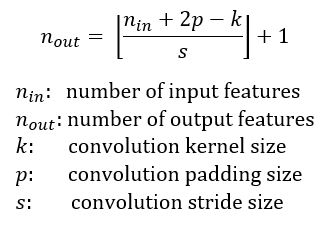

- p는 통상 1이라고 보면 됨

In [114]:
# Generator
def Generator():
  inputs = tf.keras.layers.Input(shape = [256, 256, 3])
  # norm = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 127.5, offset = -1)

  down_stack = [
                #커널 사이즈가 4인 건 feature map size가 2로 나뉘는 걸 유지하기 위함이라고 보면 됨
                downsample(64, 4, apply_instancenorm = False), # bs, 128, 128, 64
                downsample(128, 4), # 64, 64, 128
                downsample(256, 4), # 32, 32, 256
                downsample(512, 4), # 16, 16, 512
                downsample(512, 4), # 8, 8, 512
                downsample(512, 4), # 4, 4, 512
                downsample(512, 4), # 2, 2, 512
                downsample(512, 4)  # 1, 1, 512
                ]
  
  up_stack = [
              upsample(512, 4, apply_dropout = True), # Skip Connection으로 이어줄 거임 : bs, 2, 2, 1024
              upsample(512, 4, apply_dropout = True), # bs, 4, 4, 1024
              upsample(512, 4, apply_dropout = True), # bs, 8, 8, 1024
              upsample(512, 4,), # bs, 16, 16, 1024
              upsample(256, 4,), # bs, 32, 32, 512
              upsample(128, 4,), # bs, 64, 64, 256
              upsample(64, 4,), # bs, 128, 128, 128
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, # OUTPUT CHANNELS - RGB
                                        4,
                                        strides = 2,
                                        padding = 'same',
                                        kernel_initializer = initializer,
                                        activation = 'tanh') # bs, 256, 256, 3

  x = inputs
  x = norm(x) # 이미지 전처리 : [-1, 1]
  skips = []

  for down in down_stack:
    x = down(x) 
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs = inputs, outputs = x)

In [127]:
# Discriminator
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean =0.0, stddev = 0.02)

  input = keras.layers.Input(shape = [256, 256, 3], name = 'input_img')

  x = input # 얘는 정규화할 필요 없다~

  down1 = downsample(64, 4, False)(x) # bs, 128, 128, 64
  down2 = downsample(128, 4)(down1) # bs, 64, 64, 128
  down3 = downsample(256, 4)(down2) # bs, 32, 32, 256

  zero_pad1 = keras.layers.ZeroPadding2D()(down3) # bs, 34, 34, 256
  conv = keras.layers.Conv2D(512, 4, strides = 1,
                       kernel_initializer = initializer,
                       use_bias = False)(zero_pad1) # bs, 31, 31, 512 
  norm1 = tfa.layers.InstanceNormalization(gamma_initializer = gamma_init)(conv)
  leaky_relu = keras.layers.LeakyReLU()(norm1)
  
  zero_pad2 = keras.layers.ZeroPadding2D()(leaky_relu) # bs, 33, 33, 512
  last = keras.layers.Conv2D(1, 4, strides = 1,
                       kernel_initializer = initializer)(zero_pad2) # bs, 30, 30, 1
  
  return tf.keras.Model(inputs = input, outputs = last)

In [120]:
# # TPU 돌리는 건가봄
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#   print("Device : ", tpu.master())
#   tf.config.experimental_connect_to_cluster(tpu)
#   tf.tpu.expermental.initializer_tpu_system(tpu)
#   strategy = tf.distribute.experimental.TPUStrategy()
# except:
#   strategy = tf.distribute.get_strategy()
# print("Number of Replicas : ", strategy.num_replicas_in_sync)

Number of Replicas :  1


In [128]:
# Generator와 Discriminator의 구조는 동일한데 들어가는 데이터만 다름

paint_generator = Generator() # 그림을 입력으로 받는 Generator1
photo_generator = Generator() # 사진을 입력으로 받는 Generator2

paint_discriminator = Discriminator() # 진짜 그림 vs 생성된 그림 구분하는 구별기1
photo_discriminator = Discriminator() # 진짜 사진 vs 생성된 사진 구분하는 구별기2

In [129]:
paint_ex = next(iter(paint_ds))
photo_ex = next(iter(photo_ds))

In [132]:
to_paint = paint_generator(paint_ex)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


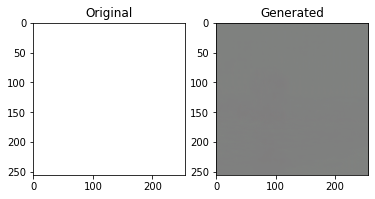

In [133]:
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(paint_ex[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title('Generated')
plt.imshow(to_paint[0] * 0.5 + 0.5 )
plt.show()